# Ratio of total CO$_2$-eq / CO$_2$ and its sensitivity to future aviation scenarios

In [1]:
# Import librairies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Climate functions
from aerometrics.utils.functions import emission_profile_function
from aerometrics.metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from aerometrics.climate_models.co2_ipcc_climate_model import CO2_IPCC_ClimateModel
from aerometrics.climate_models.gwpstar_climate_model import GWPStarClimateModel
from aerometrics.climate_models.lwe_climate_model import LWEClimateModel
from aerometrics.climate_models.fair_climate_model import FairClimateModel

## Parameters

In [2]:
# Set parameters
climate_model = "FaIR" # "GWP*", "LWE, "FaIR"
co2_method = 'FaIR' # IPCC or FaIR
profile = "pulse"

if climate_model == "FaIR":
    start_year = 1940
else:
    start_year = 2000
t0 = 2020

model_settings = {"rcp": "RCP45"} if climate_model == "FaIR" else {"tcre": 0.00045}

settings = "Lee" # "Lee", "Bickel"
species_settings = {
    "CO2": {"ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Contrails": {"sensitivity_rf": 2.23e-12, "ratio_erf_rf": 0.42 if settings == "Lee" else 0.55, "efficacy_erf": 1.0 if settings == "Lee" else 0.38},
    "NOx - ST O3 increase": {"sensitivity_rf": 25.1e-12 * (14/46), "ratio_erf_rf": 1.37, "efficacy_erf": 1.0},
    "NOx - CH4 decrease and induced": {"ch4_loss_per_nox": -3.90, "ratio_erf_rf": 1.18, "efficacy_erf": 1.0},
    "H2O": {"sensitivity_rf": 0.0052e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Soot": {"sensitivity_rf": 100.7e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
    "Sulfur": {"sensitivity_rf": -19.9e-12, "ratio_erf_rf": 1.0, "efficacy_erf": 1.0},
}

unit_values = {
    "CO2": 1*10**10,
    "Contrails": 1*10**10,
    "NOx - ST O3 increase": 1*10**10,
    "NOx - CH4 decrease and induced": 1*10**10,
    "H2O": 1*10**12,
    "Soot": 1*10**14,
    "Sulfur": 1*10**10
}

## Metrics calculation

In [3]:
# Initialisation
time_horizon_range = range(15,110,5)
gwp_rf = np.zeros((len(time_horizon_range),6))
gwp_erf = np.zeros((len(time_horizon_range),6))
egwp_rf = np.zeros((len(time_horizon_range),6))
egwp_erf = np.zeros((len(time_horizon_range),6))
gtp = np.zeros((len(time_horizon_range),6))
ratr = np.zeros((len(time_horizon_range),6))

# Loop through species and time horizons
for j, species in enumerate(["Contrails", "NOx - ST O3 increase", "NOx - CH4 decrease and induced", "H2O", "Soot", "Sulfur"]):

    for k, time_horizon in enumerate(time_horizon_range):
        end_year = t0 + time_horizon        
        emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, profile, unit_values["CO2"])
        emission_profile = emission_profile_function(start_year,t0,time_horizon, profile, unit_values[species])

        # CO2 absolute metrics
        if co2_method == 'IPCC':
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = co2_ipcc_pulse_absolute_metrics(time_horizon)
        elif co2_method == 'FaIR':
            results_co2 = FairClimateModel(
                start_year,
                end_year,
                "CO2",
                emission_profile_co2,
                species_settings["CO2"],
                model_settings
            ).run()
            radiative_forcing_co2_unit = results_co2["radiative_forcing"] / unit_values["CO2"]
            effective_radiative_forcing_co2_unit = results_co2["effective_radiative_forcing"] / unit_values["CO2"]
            temperature_co2_unit = results_co2["temperature"] / unit_values["CO2"]
            agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(
                radiative_forcing_co2_unit, 
                effective_radiative_forcing_co2_unit, 
                species_settings["CO2"].get("efficacy_erf", 1.0), 
                temperature_co2_unit, 
                time_horizon
            )

        # Species absolute metrics
        if climate_model == "GWP*":
            results = GWPStarClimateModel(start_year, end_year, species, emission_profile, species_settings[species], model_settings).run()
        elif climate_model == "LWE":
            sresults = LWEClimateModel(start_year, end_year, species, emission_profile, species_settings[species], model_settings).run()
        elif climate_model == "FaIR":
            results = FairClimateModel(start_year, end_year, species, emission_profile, species_settings[species], model_settings).run()

        unit_value = unit_values[species]
        radiative_forcing_unit = results["radiative_forcing"] / unit_value
        effective_radiative_forcing_unit = results["effective_radiative_forcing"] / unit_value
        temperature_unit = results["temperature"] / unit_value
        agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(
            radiative_forcing_unit, 
            effective_radiative_forcing_unit, 
            species_settings[species].get("efficacy_erf", 1.0),
            temperature_unit,
            time_horizon
        )

        # Relative metrics
        gwp_rf[k,j], gwp_erf[k,j], egwp_rf[k,j], egwp_erf[k,j], gtp[k,j], igtp, ratr[k,j] = relative_metrics(
            agwp_rf_co2, 
            agwp_erf_co2, 
            aegwp_rf_co2, 
            aegwp_erf_co2, 
            agtp_co2,
            iagtp_co2, 
            atr_co2, 
            agwp_rf, 
            agwp_erf,
            aegwp_rf,
            aegwp_erf, 
            agtp, 
            iagtp, 
            atr
        )

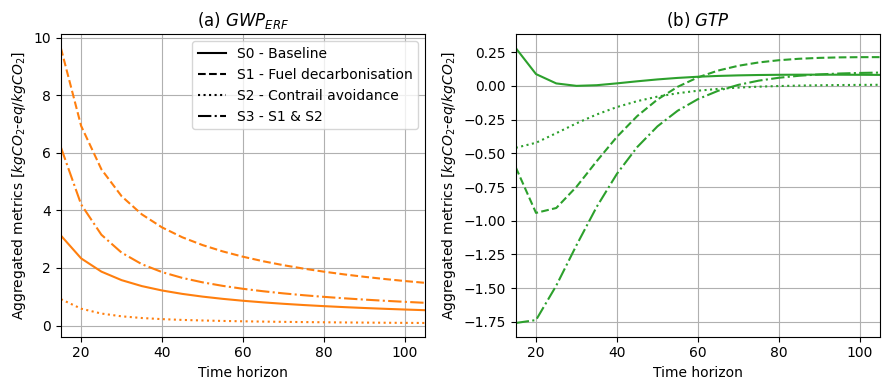

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Ratio based on 2018 data
ratio_contrails = 61.3/1033.7 # Million km / MtCO2
ratio_nox = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur = 0.37/1033.7 # MtSOx / MtCO2

# S1 - Fuel decarbonisation (including effect on contrails with sqrt(0.2))
ratio_contrails_1 = 0.447*61.3/(1033.7*0.2) # Million km / MtCO2
ratio_nox_1 = 1.4*46/14/(1033.7*0.2) # MtNOx / MtCO2
ratio_h2o_1 = 382.55/(1033.7*0.2) # MtH2O / MtCO2
ratio_soot_1 = 0.2*0.0093/(1033.7*0.2) # MtBC / MtCO2
ratio_sulfur_1 = 0*0.37/(1033.7*0.2) # MtkSOx / MtCO2

# S2 - Contrail avoidance
ratio_contrails_2 = (1-0.8)*61.3/(1033.7*1.02) # Million km / MtCO2
ratio_nox_2 = 1.4*46/14/1033.7 # MtNOx / MtCO2
ratio_h2o_2 = 382.55/1033.7 # MtH2O / MtCO2
ratio_soot_2 = 0.0093/1033.7 # MtBC / MtCO2
ratio_sulfur_2 = 0.37/1033.7 # MtSOx / MtCO2

# S3 - S1 & S2
ratio_contrails_3 = (1-0.8)*61.3/(1033.7*0.2*1.02) # Million km / MtCO2
ratio_nox_3 = 1.4*46/14/(1033.7*0.2) # MtNOx / MtCO2
ratio_h2o_3 = 382.55/(1033.7*0.2) # MtH2O / MtCO2
ratio_soot_3 = 0.2*0.0093/(1033.7*0.2) # MtBC / MtCO2
ratio_sulfur_3 = 0*0.37/(1033.7*0.2) # MtSOx / MtCO2

for i, ax in enumerate(axes.flat):
    if i == 0:
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gwp_erf[:, i+0]+ratio_nox*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o*gwp_erf[:, i+3]+ratio_soot*gwp_erf[:, i+4]+ratio_sulfur*gwp_erf[:, i+5], label='S0 - Baseline', color='C1')
        ax.plot(x_axis, ratio_contrails_1*gwp_erf[:, i+0]+ratio_nox_1*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_1*gwp_erf[:, i+3]+ratio_soot_1*gwp_erf[:, i+4]+ratio_sulfur_1*gwp_erf[:, i+5], label='S1 - Fuel decarbonisation', color='C1', linestyle="--")
        ax.plot(x_axis, ratio_contrails_2*gwp_erf[:, i+0]+ratio_nox_2*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_2*gwp_erf[:, i+3]+ratio_soot_2*gwp_erf[:, i+4]+ratio_sulfur_2*gwp_erf[:, i+5], label='S2 - Contrail avoidance', color='C1', linestyle=":")
        ax.plot(x_axis, ratio_contrails_3*gwp_erf[:, i+0]+ratio_nox_3*(gwp_erf[:, i+2]+gwp_erf[:, i+1])+ratio_h2o_3*gwp_erf[:, i+3]+ratio_soot_3*gwp_erf[:, i+4]+ratio_sulfur_3*gwp_erf[:, i+5], label='S3 - S1 & S2', color='C1', linestyle="-.")
        legend = ax.legend() 
        for legline in legend.get_lines():
            legline.set_color("black")
        ax.set_ylabel(r'Aggregated metrics [$kgCO_2\text{-}eq/kgCO_2$]')
        ax.set_title(r'(a) $GWP_{ERF}$')
    elif i == 1:
        i = 0
        x_axis = time_horizon_range
        ax.plot(x_axis, ratio_contrails*gtp[:, i+0]+ratio_nox*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o*gtp[:, i+3]+ratio_soot*gtp[:, i+4]+ratio_sulfur*gtp[:, i+5], label='S0', color='C2')
        ax.plot(x_axis, ratio_contrails_1*gtp[:, i+0]+ratio_nox_1*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_1*gtp[:, i+3]+ratio_soot_1*gtp[:, i+4]+ratio_sulfur_1*gtp[:, i+5], label='S1', color='C2', linestyle="--")
        ax.plot(x_axis, ratio_contrails_2*gtp[:, i+0]+ratio_nox_2*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_2*gtp[:, i+3]+ratio_soot_2*gtp[:, i+4]+ratio_sulfur_2*gtp[:, i+5], label='S2', color='C2', linestyle=":")
        ax.plot(x_axis, ratio_contrails_3*gtp[:, i+0]+ratio_nox_3*(gtp[:, i+2]+gtp[:, i+1])+ratio_h2o_3*gtp[:, i+3]+ratio_soot_3*gtp[:, i+4]+ratio_sulfur_3*gtp[:, i+5], label='S3', color='C2', linestyle="-.")
        #ax.legend()
        ax.set_ylabel(r'Aggregated metrics [$kgCO_2\text{-}eq/kgCO_2$]')
        ax.set_title(r'(b) $GTP$')
    ax.set_xlim(min(time_horizon_range),max(time_horizon_range))
    ax.set_xlabel('Time horizon')
    ax.grid(True)
plt.tight_layout()
plt.savefig("figures/sensitivity_to_scenarios.pdf")
plt.show()